In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
pip install easyocr

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np

In [11]:
"""
import pandas as pd
import urllib.request
from PIL import Image
import easyocr
import re
import concurrent.futures
import time
import io

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Load test CSV file
test_csv_file_path = '/kaggle/input/flipcart-dataset/student_resource 3/dataset/sample_test.csv'
test_df = pd.read_csv(test_csv_file_path)

# Function to clean misinterpreted values (e.g., "2OCM 1SCM" -> "20cm 1cm")
def correct_misinterpretations(text):
    text = text.upper()
    text = text.replace("O", "0")  # Replace O with 0
    text = text.replace("SCM", "CM")  # Correct SCM to CM
    return text

# Updated function to extract units and their values from the text (including misinterpretation handling)
def extract_units(text):
    text = correct_misinterpretations(text)
    patterns = {
        'gram': r'(\d+(\.\d+)?)\s*(g(rams?)?)',
        'kilogram': r'(\d+(\.\d+)?)\s*(kg)',
        'milligram': r'(\d+(\.\d+)?)\s*(mg)',
        'microgram': r'(\d+(\.\d+)?)\s*(µg)',
        'ounce': r'(\d+(\.\d+)?)\s*(oz)',
        'pound': r'(\d+(\.\d+)?)\s*(lb|pounds?)',
        'ton': r'(\d+(\.\d+)?)\s*(ton)',
        'centimetre': r'(\d+(\.\d+)?)\s*(cm)',
        'foot': r'(\d+(\.\d+)?)\s*(ft|feet|foot)',
        'inch': r'(\d+(\.\d+)?)\s*(in(ch)?|")',
        'metre': r'(\d+(\.\d+)?)\s*(m(etres?)?)',
        'millimetre': r'(\d+(\.\d+)?)\s*(mm)',
        'yard': r'(\d+(\.\d+)?)\s*(yd)',
        'kilovolt': r'(\d+(\.\d+)?)\s*(kv)',
        'millivolt': r'(\d+(\.\d+)?)\s*(mv)',
        'volt': r'(\d+(\.\d+)?)\s*(v)',
        'kilowatt': r'(\d+(\.\d+)?)\s*(kw)',
        'watt': r'(\d+(\.\d+)?)\s*(w)',
        'litre': r'(\d+(\.\d+)?)\s*(l(itres?)?)',
        'millilitre': r'(\d+(\.\d+)?)\s*(ml)'
    }
    units = set()
    text = text.lower()
    for unit_name, pattern in patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            extracted_value = f"{match[0]} {unit_name}" if unit_name != 'inch' else f"{match[0]} inch"
            units.add(extracted_value)
    return units

# Function to process images directly from URL without saving them
def process_image_from_url(image_link):
    try:
        with urllib.request.urlopen(image_link) as url:
            image = Image.open(io.BytesIO(url.read()))
        result = reader.readtext(image, detail=0)
        final_text = " ".join(result)
        return final_text
    except Exception as e:
        print(f"Error processing image {image_link}: {e}")
        return ""

# Function to match the extracted units with the entity name
def match_units_with_entity(entity_name, extracted_units):
    entity_unit_map = {
        'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
        'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
        'voltage': {'kilovolt', 'millivolt', 'volt'},
        'wattage': {'kilowatt', 'watt'},
        'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
    }
    valid_units = entity_unit_map.get(entity_name, set())
    relevant_units = [unit for unit in extracted_units if any(valid_unit in unit for valid_unit in valid_units)]
    return relevant_units

# Function to process each row and return results with the index
def process_row(row, index):
    image_url = row['image_link']
    entity_name = row['entity_name']
    group_id = row['group_id']
    final_text = process_image_from_url(image_url)
    extracted_units = extract_units(final_text)
    matched_units = match_units_with_entity(entity_name, extracted_units)
    predicted_value = ", ".join(matched_units) if matched_units else ""
    return {
        'index': index,  # Add the index here
        'image_link': image_url,
        'entity_name': entity_name,
        'group_id': group_id,
        'extracted_text': final_text,
        'predicted_units': matched_units,
        'predicted': predicted_value
    }

# Initialize list to store test results
test_results = []

# Start tracking time
start_time = time.time()

# Use ThreadPoolExecutor for concurrent processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Process each row in parallel
    future_to_row = {executor.submit(process_row, row, index): (row, index) for index, row in test_df.iterrows()}
    
    for index, future in enumerate(concurrent.futures.as_completed(future_to_row)):
        try:
            result_row = future.result()
            test_results.append(result_row)
            
            # Calculate elapsed time and remaining time
            elapsed_time = time.time() - start_time
            remaining_images = len(test_df) - (index + 1)
            estimated_total_time = (elapsed_time / (index + 1)) * len(test_df)
            remaining_time = estimated_total_time - elapsed_time
            
            # Print progress
            print(f"Processed {index + 1}/{len(test_df)} test images. Estimated time remaining: {remaining_time // 60:.0f}m {remaining_time % 60:.0f}s")
        except Exception as e:
            print(f"Error processing row: {e}")

# Calculate final elapsed time
total_elapsed_time = time.time() - start_time

# Create DataFrame and save test results to CSV
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('test_matched_units.csv', index=False)

print(f"Processed {len(test_results)} test images in {total_elapsed_time // 60:.0f}m {total_elapsed_time % 60:.0f}s")

"""

'\nimport pandas as pd\nimport urllib.request\nfrom PIL import Image\nimport easyocr\nimport re\nimport concurrent.futures\nimport time\nimport io\n\n# Initialize EasyOCR reader\nreader = easyocr.Reader([\'en\'])\n\n# Load test CSV file\ntest_csv_file_path = \'/kaggle/input/flipcart-dataset/student_resource 3/dataset/sample_test.csv\'\ntest_df = pd.read_csv(test_csv_file_path)\n\n# Function to clean misinterpreted values (e.g., "2OCM 1SCM" -> "20cm 1cm")\ndef correct_misinterpretations(text):\n    text = text.upper()\n    text = text.replace("O", "0")  # Replace O with 0\n    text = text.replace("SCM", "CM")  # Correct SCM to CM\n    return text\n\n# Updated function to extract units and their values from the text (including misinterpretation handling)\ndef extract_units(text):\n    text = correct_misinterpretations(text)\n    patterns = {\n        \'gram\': r\'(\\d+(\\.\\d+)?)\\s*(g(rams?)?)\',\n        \'kilogram\': r\'(\\d+(\\.\\d+)?)\\s*(kg)\',\n        \'milligram\': r\'(\\d+(\\.\

In [12]:
"""
import pandas as pd
import re
import numpy as np  # Import numpy for handling NaN values

def extract_number(value):
    match = re.search(r'(\d+\.?\d*)', value)
    if match:
        return float(match.group(1))
    return None

def convert_to_base_unit(value, unit):
    conversions = {
        'cm': 1,
        'centimetre': 1,
        'inch': 2.54,
        'foot': 30.48,
        'yard': 91.44,
        'watt': 1,  # Assuming 'watt' does not need conversion
        'gram': 1,
        'kilogram': 1000,
        'ounce': 28.3495,
        'pound': 453.592
    }
    return value * conversions.get(unit, 1)

def find_max_value(predicted_units):
    if not predicted_units or pd.isna(predicted_units):
        return np.nan  # Return NaN when predicted_units is empty or NaN

    max_value = -float('inf')
    max_unit = None
    parts = predicted_units.split(',')

    for part in parts:
        number_match = re.search(r'(\d+\.?\d*)', part)
        unit_match = re.search(r'(cm|centimetre|inch|foot|yard|watt|gram|kilogram|ounce|pound|meter|metre|volt)', part, re.IGNORECASE)
        if number_match and unit_match:
            number = float(number_match.group(1))
            unit = unit_match.group(1).lower()
            value_in_base = convert_to_base_unit(number, unit)
            if value_in_base > max_value:
                max_value = value_in_base
                max_unit = part
    
    return max_unit if max_unit else np.nan  # Return NaN if no valid unit found

# Apply the function
df['max_predicted_units'] = df['predicted_units'].apply(lambda x: find_max_value(x))

print(df[['image_link', 'entity_name', 'predicted_units', 'max_predicted_units']].head(30))

"""

"\nimport pandas as pd\nimport re\nimport numpy as np  # Import numpy for handling NaN values\n\ndef extract_number(value):\n    match = re.search(r'(\\d+\\.?\\d*)', value)\n    if match:\n        return float(match.group(1))\n    return None\n\ndef convert_to_base_unit(value, unit):\n    conversions = {\n        'cm': 1,\n        'centimetre': 1,\n        'inch': 2.54,\n        'foot': 30.48,\n        'yard': 91.44,\n        'watt': 1,  # Assuming 'watt' does not need conversion\n        'gram': 1,\n        'kilogram': 1000,\n        'ounce': 28.3495,\n        'pound': 453.592\n    }\n    return value * conversions.get(unit, 1)\n\ndef find_max_value(predicted_units):\n    if not predicted_units or pd.isna(predicted_units):\n        return np.nan  # Return NaN when predicted_units is empty or NaN\n\n    max_value = -float('inf')\n    max_unit = None\n    parts = predicted_units.split(',')\n\n    for part in parts:\n        number_match = re.search(r'(\\d+\\.?\\d*)', part)\n        unit

In [ ]:
"""
import pandas as pd
import urllib.request
from PIL import Image, ImageEnhance
import easyocr
import re
import concurrent.futures
import time
import io
import numpy as np

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Load test CSV file
test_csv_file_path = '/kaggle/input/flipcart-dataset/student_resource 3/dataset/sample_test.csv'
test_df = pd.read_csv(test_csv_file_path)

# Function to clean misinterpreted values (e.g., "2OCM 1SCM" -> "20cm 1cm")
def correct_misinterpretations(text):
    text = text.upper()
    text = text.replace("O", "0")  # Replace O with 0
    text = text.replace("SCM", "CM")  # Correct SCM to CM
    return text

# Updated function to extract units and their values from the text (including misinterpretation handling)
def extract_units(text):
    text = correct_misinterpretations(text)
    patterns = {
        'gram': r'(\d+(\.\d+)?)\s*(g(rams?)?)',
        'kilogram': r'(\d+(\.\d+)?)\s*(kg)',
        'milligram': r'(\d+(\.\d+)?)\s*(mg)',
        'microgram': r'(\d+(\.\d+)?)\s*(µg)',
        'ounce': r'(\d+(\.\d+)?)\s*(oz)',
        'pound': r'(\d+(\.\d+)?)\s*(lb|pounds?)',
        'ton': r'(\d+(\.\d+)?)\s*(ton)',
        'centimetre': r'(\d+(\.\d+)?)\s*(cm)',
        'foot': r'(\d+(\.\d+)?)\s*(ft|feet|foot)',
        'inch': r'(\d+(\.\d+)?)\s*(in(ch)?|")',
        'metre': r'(\d+(\.\d+)?)\s*(m(etres?)?)',
        'millimetre': r'(\d+(\.\d+)?)\s*(mm)',
        'yard': r'(\d+(\.\d+)?)\s*(yd)',
        'kilovolt': r'(\d+(\.\d+)?)\s*(kv)',
        'millivolt': r'(\d+(\.\d+)?)\s*(mv)',
        'volt': r'(\d+(\.\d+)?)\s*(v)',
        'kilowatt': r'(\d+(\.\d+)?)\s*(kw)',
        'watt': r'(\d+(\.\d+)?)\s*(w)',
        'litre': r'(\d+(\.\d+)?)\s*(l(itres?)?)',
        'millilitre': r'(\d+(\.\d+)?)\s*(ml)'
    }
    units = set()
    text = text.lower()
    for unit_name, pattern in patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            extracted_value = f"{match[0]} {unit_name}" if unit_name != 'inch' else f"{match[0]} inch"
            units.add(extracted_value)
    return units

# Function to rotate image at different angles and zoom for better text extraction
def rotate_and_zoom_image(image):
    rotated_images = []
    for angle in [0, 90, 180, 270]:  # Four possible rotations
        rotated_img = image.rotate(angle)
        rotated_images.append(rotated_img)
        
        # Enhance zoom by increasing sharpness and contrast if the text is small
        enhancer = ImageEnhance.Sharpness(rotated_img)
        sharpened_img = enhancer.enhance(2.0)  # Sharpening the image
        rotated_images.append(sharpened_img)
        
        contrast_enhancer = ImageEnhance.Contrast(rotated_img)
        contrast_img = contrast_enhancer.enhance(2.0)  # Increasing contrast
        rotated_images.append(contrast_img)
    return rotated_images

# Function to process images directly from URL without saving them
def process_image_from_url(image_link):
    try:
        with urllib.request.urlopen(image_link) as url:
            image = Image.open(io.BytesIO(url.read()))
        
        # Convert to numpy array and apply rotation/zoom
        images_to_check = rotate_and_zoom_image(image)
        extracted_texts = []
        for img in images_to_check:
            np_image = np.array(img)
            result = reader.readtext(np_image, detail=0)
            final_text = " ".join(result)
            extracted_texts.append(final_text)
        
        # Join all extracted text from rotated/zoomed images
        return " ".join(extracted_texts)
    except Exception as e:
        print(f"Error processing image {image_link}: {e}")
        return ""

# Function to match the extracted units with the entity name
def match_units_with_entity(entity_name, extracted_units):
    entity_unit_map = {
        'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
        'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
        'voltage': {'kilovolt', 'millivolt', 'volt'},
        'wattage': {'kilowatt', 'watt'},
        'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
    }
    valid_units = entity_unit_map.get(entity_name, set())
    relevant_units = [unit for unit in extracted_units if any(valid_unit in unit for valid_unit in valid_units)]
    return relevant_units

# Function to process each row and return results with the index
def process_row(row, index):
    image_url = row['image_link']
    entity_name = row['entity_name']
    group_id = row['group_id']
    final_text = process_image_from_url(image_url)
    extracted_units = extract_units(final_text)
    matched_units = match_units_with_entity(entity_name, extracted_units)
    predicted_value = ", ".join(matched_units) if matched_units else ""
    return {
        'index': index,  # Add the index here
        'image_link': image_url,
        'entity_name': entity_name,
        'group_id': group_id,
        'extracted_text': final_text,
        'predicted_units': matched_units,
        'predicted': predicted_value
    }

# Initialize list to store test results
test_results = []

# Start tracking time
start_time = time.time()

# Use ThreadPoolExecutor for concurrent processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Process each row in parallel
    future_to_row = {executor.submit(process_row, row, index): (row, index) for index, row in test_df.iterrows()}
    
    for index, future in enumerate(concurrent.futures.as_completed(future_to_row)):
        try:
            result_row = future.result()
            test_results.append(result_row)
            
            # Calculate elapsed time and remaining time
            elapsed_time = time.time() - start_time
            remaining_images = len(test_df) - (index + 1)
            estimated_total_time = (elapsed_time / (index + 1)) * len(test_df)
            remaining_time = estimated_total_time - elapsed_time
            
            # Print progress
            print(f"Processed {index + 1}/{len(test_df)} test images. Estimated time remaining: {remaining_time // 60:.0f}m {remaining_time % 60:.0f}s")
        except Exception as e:
            print(f"Error processing row: {e}")

# Calculate final elapsed time
total_elapsed_time = time.time() - start_time

# Create DataFrame and save test results to CSV
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('test_matched_units.csv', index=False)

print(f"Processed {len(test_results)} test images in {total_elapsed_time // 60:.0f}m {total_elapsed_time % 60:.0f}s")
"""

In [ ]:
"""import pandas as pd
import urllib.request
from PIL import Image, ImageEnhance
import easyocr
import re
import concurrent.futures
import time
import io
import numpy as np
import torch

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)  # Ensure GPU usage is set

# Load test CSV file
test_csv_file_path = '/kaggle/input/flipcart-dataset/student_resource 3/dataset/sample_test.csv'
test_df = pd.read_csv(test_csv_file_path)

# Function to clean misinterpreted values (e.g., "2OCM 1SCM" -> "20cm 1cm")
def correct_misinterpretations(text):
    text = text.upper()
    text = text.replace("O", "0")  # Replace O with 0
    text = text.replace("SCM", "CM")  # Correct SCM to CM
    return text

# Updated function to extract units and their values from the text
def extract_units(text):
    text = correct_misinterpretations(text)
    patterns = {
        'gram': r'(\d+(\.\d+)?)\s*(g(rams?)?)',
        'kilogram': r'(\d+(\.\d+)?)\s*(kg)',
        'milligram': r'(\d+(\.\d+)?)\s*(mg)',
        'microgram': r'(\d+(\.\d+)?)\s*(µg)',
        'ounce': r'(\d+(\.\d+)?)\s*(oz)',
        'pound': r'(\d+(\.\d+)?)\s*(lb|pounds?)',
        'ton': r'(\d+(\.\d+)?)\s*(ton)',
        'centimetre': r'(\d+(\.\d+)?)\s*(cm)',
        'foot': r'(\d+(\.\d+)?)\s*(ft|feet|foot)',
        'inch': r'(\d+(\.\d+)?)\s*(in(ch)?|")',
        'metre': r'(\d+(\.\d+)?)\s*(m(etres?)?)',
        'millimetre': r'(\d+(\.\d+)?)\s*(mm)',
        'yard': r'(\d+(\.\d+)?)\s*(yd)',
        'kilovolt': r'(\d+(\.\d+)?)\s*(kv)',
        'millivolt': r'(\d+(\.\d+)?)\s*(mv)',
        'volt': r'(\d+(\.\d+)?)\s*(v)',
        'kilowatt': r'(\d+(\.\d+)?)\s*(kw)',
        'watt': r'(\d+(\.\d+)?)\s*(w)',
        'litre': r'(\d+(\.\d+)?)\s*(l(itres?)?)',
        'millilitre': r'(\d+(\.\d+)?)\s*(ml)'
    }
    units = set()
    text = text.lower()
    for unit_name, pattern in patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            extracted_value = f"{match[0]} {unit_name}" if unit_name != 'inch' else f"{match[0]} inch"
            units.add(extracted_value)
    return units

# Function to rotate and zoom the image
def rotate_and_zoom_image(image):
    rotated_images = []
    zoom_factors = [1.0, 1.5, 2.0]  # Zoom levels

    for angle in [0, 90, 180, 270]:  # Rotate at different angles
        rotated_img = image.rotate(angle)

        for zoom in zoom_factors:  # Apply zoom at each angle
            width, height = rotated_img.size
            zoomed_img = rotated_img.resize((int(width * zoom), int(height * zoom)))
            rotated_images.append(zoomed_img)

            # Apply sharpness enhancement for better clarity
            enhancer = ImageEnhance.Sharpness(zoomed_img)
            sharpened_img = enhancer.enhance(2.0)
            rotated_images.append(sharpened_img)

            # Apply contrast enhancement
            contrast_enhancer = ImageEnhance.Contrast(zoomed_img)
            contrast_img = contrast_enhancer.enhance(2.0)
            rotated_images.append(contrast_img)

    return rotated_images

# Function to process images directly from URL without saving them
def process_image_from_url(image_link):
    try:
        with urllib.request.urlopen(image_link) as url:
            image = Image.open(io.BytesIO(url.read()))

        # Resize the image to avoid memory issues (downscaling)
        max_size = (1024, 1024)
        image.thumbnail(max_size)

        # Rotate and zoom image
        images_to_check = rotate_and_zoom_image(image)
        extracted_texts = []
        for img in images_to_check:
            np_image = np.array(img)
            result = reader.readtext(np_image, detail=0)
            final_text = " ".join(result)
            extracted_texts.append(final_text)

            # Clear CUDA cache after processing each image to avoid memory overload
            torch.cuda.empty_cache()

        # Join all extracted text from rotated and zoomed images
        return " ".join(extracted_texts)
    except Exception as e:
        print(f"Error processing image {image_link}: {e}")
        return ""

# Function to match the extracted units with the entity name
def match_units_with_entity(entity_name, extracted_units):
    entity_unit_map = {
        'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
        'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
        'voltage': {'kilovolt', 'millivolt', 'volt'},
        'wattage': {'kilowatt', 'watt'},
        'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
    }
    valid_units = entity_unit_map.get(entity_name, set())
    relevant_units = [unit for unit in extracted_units if any(valid_unit in unit for valid_unit in valid_units)]
    return relevant_units

# Function to process each row and return results with the index
def process_row(row, index):
    image_url = row['image_link']
    entity_name = row['entity_name']
    group_id = row['group_id']
    final_text = process_image_from_url(image_url)
    extracted_units = extract_units(final_text)
    matched_units = match_units_with_entity(entity_name, extracted_units)
    predicted_value = ", ".join(matched_units) if matched_units else ""
    return {
        'index': index,
        'image_link': image_url,
        'entity_name': entity_name,
        'group_id': group_id,
        'extracted_text': final_text,
        'predicted_units': matched_units,
        'predicted': predicted_value
    }

# Initialize list to store test results
test_results = []

# Start tracking time
start_time = time.time()

# Use ThreadPoolExecutor for concurrent processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Process each row in parallel
    future_to_row = {executor.submit(process_row, row, index): (row, index) for index, row in test_df.iterrows()}
    
    for index, future in enumerate(concurrent.futures.as_completed(future_to_row)):
        try:
            result_row = future.result()
            test_results.append(result_row)

            # Calculate elapsed time and remaining time
            elapsed_time = time.time() - start_time
            remaining_images = len(test_df) - (index + 1)
            estimated_total_time = (elapsed_time / (index + 1)) * len(test_df)
            remaining_time = estimated_total_time - elapsed_time
            print(f"Processed {index + 1}/{len(test_df)} test images. Estimated time remaining: {int(remaining_time // 60)}m {int(remaining_time % 60)}s")
        except Exception as exc:
            print(f"Error in row {index}: {exc}")

# Convert results to DataFrame and save to CSV
output_df = pd.DataFrame(test_results)
output_csv_file_path = '/kaggle/working/test_results.csv'
output_df.to_csv(output_csv_file_path, index=False)

print("Test processing completed.")

"""

# main code

In [13]:
import pandas as pd
import urllib.request
from PIL import Image, ImageEnhance
import easyocr
import re
import concurrent.futures
import time
import io
import numpy as np

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Load test CSV file
test_csv_file_path = '/kaggle/input/grocery-dataset/Grocery dataset.csv'
test_df = pd.read_csv(test_csv_file_path)

# Function to clean misinterpreted values (e.g., "2OCM 1SCM" -> "20cm 1cm")
def correct_misinterpretations(text):
    text = text.upper()
    text = text.replace("O", "0")  # Replace O with 0
    text = text.replace("SCM", "CM")  # Correct SCM to CM
    return text

# Updated function to extract units and their values from the text (including misinterpretation handling)
def extract_units(text):
    text = correct_misinterpretations(text)
    patterns = {
        'gram': r'(\d+(\.\d+)?)\s*(g(rams?)?)',
        'kilogram': r'(\d+(\.\d+)?)\s*(kg)',
        'milligram': r'(\d+(\.\d+)?)\s*(mg)',
        'microgram': r'(\d+(\.\d+)?)\s*(µg)',
        'ounce': r'(\d+(\.\d+)?)\s*(oz)',
        'pound': r'(\d+(\.\d+)?)\s*(lb|pounds?)',
        'ton': r'(\d+(\.\d+)?)\s*(ton)',
        'centimetre': r'(\d+(\.\d+)?)\s*(cm)',
        'foot': r'(\d+(\.\d+)?)\s*(ft|feet|foot)',
        'inch': r'(\d+(\.\d+)?)\s*(in(ch)?|")',
        'metre': r'(\d+(\.\d+)?)\s*(m(etres?)?)',
        'millimetre': r'(\d+(\.\d+)?)\s*(mm)',
        'yard': r'(\d+(\.\d+)?)\s*(yd)',
        'kilovolt': r'(\d+(\.\d+)?)\s*(kv)',
        'millivolt': r'(\d+(\.\d+)?)\s*(mv)',
        'volt': r'(\d+(\.\d+)?)\s*(v)',
        'kilowatt': r'(\d+(\.\d+)?)\s*(kw)',
        'watt': r'(\d+(\.\d+)?)\s*(w)',
        'litre': r'(\d+(\.\d+)?)\s*(l(itres?)?)',
        'millilitre': r'(\d+(\.\d+)?)\s*(ml)'
    }
    units = set()
    text = text.lower()
    for unit_name, pattern in patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            extracted_value = f"{match[0]} {unit_name}" if unit_name != 'inch' else f"{match[0]} inch"
            units.add(extracted_value)
    return units

# Function to rotate image at different angles and zoom for better text extraction
def rotate_and_zoom_image(image):
    rotated_images = []
    for angle in [0, 90, 180, 270]:  # Four possible rotations
        rotated_img = image.rotate(angle)
        rotated_images.append(rotated_img)
        
        # Enhance zoom by increasing sharpness and contrast if the text is small
        enhancer = ImageEnhance.Sharpness(rotated_img)
        sharpened_img = enhancer.enhance(2.0)  # Sharpening the image
        rotated_images.append(sharpened_img)
        
        contrast_enhancer = ImageEnhance.Contrast(rotated_img)
        contrast_img = contrast_enhancer.enhance(2.0)  # Increasing contrast
        rotated_images.append(contrast_img)
    return rotated_images

# Function to process images directly from URL without saving them
def process_image_from_url(image_link):
    try:
        with urllib.request.urlopen(image_link) as url:
            image = Image.open(io.BytesIO(url.read()))
        
        # Convert to numpy array and apply rotation/zoom
        images_to_check = rotate_and_zoom_image(image)
        extracted_texts = []
        for img in images_to_check:
            np_image = np.array(img)
            result = reader.readtext(np_image, detail=0)
            final_text = " ".join(result)
            extracted_texts.append(final_text)
        
        # Join all extracted text from rotated/zoomed images
        return " ".join(extracted_texts)
    except Exception as e:
        print(f"Error processing image {image_link}: {e}")
        return ""

# Function to match the extracted units with the entity name
def match_units_with_entity(entity_name, extracted_units):
    entity_unit_map = {
        'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
        'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
        'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
        'voltage': {'kilovolt', 'millivolt', 'volt'},
        'wattage': {'kilowatt', 'watt'},
        'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
    }
    valid_units = entity_unit_map.get(entity_name, set())
    relevant_units = [unit for unit in extracted_units if any(valid_unit in unit for valid_unit in valid_units)]
    return relevant_units

# Function to process each row and return results with the index
def process_row(row, index):
    image_url = row['image_link']
    entity_name = row['entity_name']
    group_id = row['group_id']
    final_text = process_image_from_url(image_url)
    extracted_units = extract_units(final_text)
    matched_units = match_units_with_entity(entity_name, extracted_units)
    predicted_value = ", ".join(matched_units) if matched_units else ""
    
    # Include all input columns in the output by updating the result dictionary with row values
    result = row.to_dict()
    result.update({
        'extracted_text': final_text,
        'predicted_units': matched_units,
        'predicted': predicted_value
    })
    return result

# Initialize list to store test results
test_results = []

# Start tracking time
start_time = time.time()

# Use ThreadPoolExecutor for concurrent processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Limit the rows to 10 for processing
    limited_test_df = test_df.head(150)
    
    # Process each row in parallel
    future_to_row = {executor.submit(process_row, row, index): (row, index) for index, row in limited_test_df.iterrows()}
    
    for index, future in enumerate(concurrent.futures.as_completed(future_to_row)):
        try:
            result_row = future.result()
            test_results.append(result_row)
            
            # Calculate elapsed time and remaining time
            elapsed_time = time.time() - start_time
            remaining_images = len(limited_test_df) - (index + 1)
            estimated_total_time = (elapsed_time / (index + 1)) * len(limited_test_df)
            remaining_time = estimated_total_time - elapsed_time
            
            # Print progress
            print(f"Processed {index + 1}/{len(limited_test_df)} test images. Estimated time remaining: {remaining_time // 60:.0f}m {remaining_time % 60:.0f}s")
        except Exception as e:
            print(f"Error processing row: {e}")

# Calculate final elapsed time
total_elapsed_time = time.time() - start_time

# Create DataFrame and save test results to CSV
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('test_matched_units.csv', index=False)

print(f"Processed {len(test_results)} test images in {total_elapsed_time // 60:.0f}m {total_elapsed_time % 60:.0f}s")


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Processed 1/150 test images. Estimated time remaining: 114m 38s
Processed 2/150 test images. Estimated time remaining: 75m 24s
Processed 3/150 test images. Estimated time remaining: 53m 4s
Processed 4/150 test images. Estimated time remaining: 49m 10s
Processed 5/150 test images. Estimated time remaining: 39m 4s
Processed 6/150 test images. Estimated time remaining: 36m 10s
Processed 7/150 test images. Estimated time remaining: 36m 28s
Processed 8/150 test images. Estimated time remaining: 40m 14s
Processed 9/150 test images. Estimated time remaining: 38m 46s
Processed 10/150 test images. Estimated time remaining: 36m 8s
Processed 11/150 test images. Estimated time remaining: 34m 22s
Processed 12/150 test images. Estimated time remaining: 31m 44s
Processed 13/150 test images. Estimated time remaining: 38m 23s
Processed 14/150 test images. Estimated time remaining: 36m 47s
Processed 15/150 test images. Estimated time remaining: 36m 34s
Processed 16/150 test images. Estimated time remain

In [3]:
final_df = pd.read_csv('test_matched_units.csv')

In [63]:
#final_df = final_df.drop(columns=['predicted_units', 'group_id'])

In [64]:
final_df.head(30)

,image_link,group_id,entity_name,entity_value,extracted_text,predicted_units,predicted
0,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram,Horbaach' HIGH StRENGTH PSYLLIUM HUSK PLANTAGO...,['1400 milligram'],1400 milligram
1,https://m.media-amazon.com/images/I/61oMj2iXOu...,308856,item_weight,15 kilogram,"WILDFANG M XS 8 M Xi 1,3 cm 2 cm 2,5 cm 3 cm 3...","['25 kilogram', '15 kilogram', '10 kilogram', ...","25 kilogram, 15 kilogram, 10 kilogram, 45 kilo..."
2,https://m.media-amazon.com/images/I/81N73b5khV...,149159,item_weight,30.0 kilogram,GroBe Kapazilat; Tragialigkeit bis zu 30KG Das...,"['30 kilogram', '8 gram']","30 kilogram, 8 gram"
3,https://m.media-amazon.com/images/I/71DiLRHeZd...,731432,item_weight,1400 milligram,VEGAN WHEAT FREE soy FREE OVATA DAIRY FREE FRE...,['1400 milligram'],1400 milligram
4,https://m.media-amazon.com/images/I/61QsBSE7jg...,731432,item_weight,1400 milligram,Naturally-Sourced Psyllium High strength 140Om...,['1400 milligram'],1400 milligram
5,https://m.media-amazon.com/images/I/71jBLhmTNl...,731432,item_weight,1400 milligram,NEW LOOK SAME TRUSTEDQUALITY OLD Horbaach NEW ...,"['400 milligram', '2 gram', '1400 milligram']","400 milligram, 2 gram, 1400 milligram"
6,https://m.media-amazon.com/images/I/91Cma3Rzse...,731432,item_weight,1400 milligram,Horbaach V 100% HIGHEST QUALITY TO HGH GMP ) H...,"['8 gram', '0 gram', '1400 milligram']","8 gram, 0 gram, 1400 milligram"
7,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram,PROPOS' NATUREJ INGREDIENT MENAGER MULTI-USAGE...,"['0 gram', '00 gram', '500 gram']","0 gram, 00 gram, 500 gram"
8,https://m.media-amazon.com/images/I/61wzlucTRE...,252585,item_volume,4.0 litre,ONE SIZE FITS ALL STRETCHABLE AND BLACK FABRIC...,"['3 litre', '1 litre', '4 litre', '0 litre']","3 litre, 1 litre, 4 litre, 0 litre"
9,https://m.media-amazon.com/images/I/61sQ+qAKr4...,299791,item_weight,2.7 gram,925 Sterling Silver 18K Gold Plated 0.28 INCH ...,['2.7 gram'],2.7 gram


In [65]:
# Convert 'predicted' column from a list of strings to a single string without brackets and quotes
final_df['predicted_units'] = final_df['predicted_units'].apply(lambda x: ', '.join(sorted(set(x.strip('[]').replace("'", "").split(', ')))))

In [66]:
df = final_df

In [67]:
import pandas as pd
import re
import numpy as np  # Import numpy for handling NaN values

def extract_number(value):
    """Extract the number from a value string."""
    match = re.search(r'(\d+\.?\d*)', value)
    if match:
        return float(match.group(1))
    return None

def convert_to_base_unit(value, unit):
    """Convert the value to a base unit (e.g., centimeters)."""
    conversions = {
        'cm': 1,
        'centimetre': 1,
        'inch': 2.54,
        'foot': 30.48,
        'yard': 91.44,
        'watt': 1,  # Assuming 'watt' does not need conversion
        'gram': 1,
        'kilogram': 1000,
        'ounce': 28.3495,
        'pound': 453.592
    }
    return value * conversions.get(unit, 1)

def find_max_value(predicted_units):
    """Find the maximum value in the predicted_units column, return NaN if empty."""
    if not predicted_units or pd.isna(predicted_units):
        return np.nan  # Return NaN when predicted_units is empty or NaN

    max_value = -float('inf')
    max_unit = None
    parts = predicted_units.split(',')

    for part in parts:
        number_match = re.search(r'(\d+\.?\d*)', part)
        unit_match = re.search(r'(cm|centimetre|inch|foot|yard|watt|gram|kilogram|ounce|pound|meter|metre|volt)', part, re.IGNORECASE)
        if number_match and unit_match:
            number = float(number_match.group(1))
            unit = unit_match.group(1).lower()
            value_in_base = convert_to_base_unit(number, unit)
            if value_in_base > max_value:
                max_value = value_in_base
                max_unit = part
    
    return max_unit if max_unit else np.nan  # Return NaN if no valid unit found

# Apply the function
df['max_predicted_units'] = df['predicted_units'].apply(lambda x: find_max_value(x))

print(df[['image_link', 'entity_name', 'predicted_units', 'max_predicted_units']].head(30))

                                           image_link  entity_name  \
0   https://m.media-amazon.com/images/I/617Tl40LOX...  item_weight   
1   https://m.media-amazon.com/images/I/61oMj2iXOu...  item_weight   
2   https://m.media-amazon.com/images/I/81N73b5khV...  item_weight   
3   https://m.media-amazon.com/images/I/71DiLRHeZd...  item_weight   
4   https://m.media-amazon.com/images/I/61QsBSE7jg...  item_weight   
5   https://m.media-amazon.com/images/I/71jBLhmTNl...  item_weight   
6   https://m.media-amazon.com/images/I/91Cma3Rzse...  item_weight   
7   https://m.media-amazon.com/images/I/61I9XdN6OF...  item_weight   
8   https://m.media-amazon.com/images/I/61wzlucTRE...  item_volume   
9   https://m.media-amazon.com/images/I/61sQ+qAKr4...  item_weight   
10  https://m.media-amazon.com/images/I/81fOxWWWKY...  item_weight   
11  https://m.media-amazon.com/images/I/61XGDKap+J...  item_weight   
12  https://m.media-amazon.com/images/I/51WsuKKAVr...  item_weight   
13  https://m.media-

In [68]:
df_m = df

In [69]:
df_m.head(30)

,image_link,group_id,entity_name,entity_value,extracted_text,predicted_units,predicted,max_predicted_units
0,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram,Horbaach' HIGH StRENGTH PSYLLIUM HUSK PLANTAGO...,1400 milligram,1400 milligram,1400 milligram
1,https://m.media-amazon.com/images/I/61oMj2iXOu...,308856,item_weight,15 kilogram,"WILDFANG M XS 8 M Xi 1,3 cm 2 cm 2,5 cm 3 cm 3...","10 kilogram, 15 kilogram, 25 kilogram, 45 kilo...","25 kilogram, 15 kilogram, 10 kilogram, 45 kilo...",45 kilogram
2,https://m.media-amazon.com/images/I/81N73b5khV...,149159,item_weight,30.0 kilogram,GroBe Kapazilat; Tragialigkeit bis zu 30KG Das...,"30 kilogram, 8 gram","30 kilogram, 8 gram",30 kilogram
3,https://m.media-amazon.com/images/I/71DiLRHeZd...,731432,item_weight,1400 milligram,VEGAN WHEAT FREE soy FREE OVATA DAIRY FREE FRE...,1400 milligram,1400 milligram,1400 milligram
4,https://m.media-amazon.com/images/I/61QsBSE7jg...,731432,item_weight,1400 milligram,Naturally-Sourced Psyllium High strength 140Om...,1400 milligram,1400 milligram,1400 milligram
5,https://m.media-amazon.com/images/I/71jBLhmTNl...,731432,item_weight,1400 milligram,NEW LOOK SAME TRUSTEDQUALITY OLD Horbaach NEW ...,"1400 milligram, 2 gram, 400 milligram","400 milligram, 2 gram, 1400 milligram",1400 milligram
6,https://m.media-amazon.com/images/I/91Cma3Rzse...,731432,item_weight,1400 milligram,Horbaach V 100% HIGHEST QUALITY TO HGH GMP ) H...,"0 gram, 1400 milligram, 8 gram","8 gram, 0 gram, 1400 milligram",1400 milligram
7,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram,PROPOS' NATUREJ INGREDIENT MENAGER MULTI-USAGE...,"0 gram, 00 gram, 500 gram","0 gram, 00 gram, 500 gram",500 gram
8,https://m.media-amazon.com/images/I/61wzlucTRE...,252585,item_volume,4.0 litre,ONE SIZE FITS ALL STRETCHABLE AND BLACK FABRIC...,"0 litre, 1 litre, 3 litre, 4 litre","3 litre, 1 litre, 4 litre, 0 litre",NaN
9,https://m.media-amazon.com/images/I/61sQ+qAKr4...,299791,item_weight,2.7 gram,925 Sterling Silver 18K Gold Plated 0.28 INCH ...,2.7 gram,2.7 gram,2.7 gram


In [70]:
from difflib import SequenceMatcher

# Function to calculate similarity between two strings
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Create new columns for counting repetitions
df_m['no_of_items_text'] = 0
df_m['no_of_items_image'] = 0

# Loop through extracted text values and count matches greater than 80%
for i, text in enumerate(df_m['extracted_text']):
    match_count_text = sum(similar(text, other_text) >= 0.8 for other_text in df_m['extracted_text'])
    df_m.loc[i, 'no_of_items_text'] = match_count_text

# Loop through image URLs and count exact matches
for i, url in enumerate(df_m['image_link']):
    match_count_image = df_m['image_link'].value_counts().get(url, 0)
    df_m.loc[i, 'no_of_items_image'] = match_count_image

In [71]:
df_m.head(30)

,image_link,group_id,entity_name,entity_value,extracted_text,predicted_units,predicted,max_predicted_units,no_of_items_text,no_of_items_image
0,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram,Horbaach' HIGH StRENGTH PSYLLIUM HUSK PLANTAGO...,1400 milligram,1400 milligram,1400 milligram,1,1
1,https://m.media-amazon.com/images/I/61oMj2iXOu...,308856,item_weight,15 kilogram,"WILDFANG M XS 8 M Xi 1,3 cm 2 cm 2,5 cm 3 cm 3...","10 kilogram, 15 kilogram, 25 kilogram, 45 kilo...","25 kilogram, 15 kilogram, 10 kilogram, 45 kilo...",45 kilogram,1,1
2,https://m.media-amazon.com/images/I/81N73b5khV...,149159,item_weight,30.0 kilogram,GroBe Kapazilat; Tragialigkeit bis zu 30KG Das...,"30 kilogram, 8 gram","30 kilogram, 8 gram",30 kilogram,1,1
3,https://m.media-amazon.com/images/I/71DiLRHeZd...,731432,item_weight,1400 milligram,VEGAN WHEAT FREE soy FREE OVATA DAIRY FREE FRE...,1400 milligram,1400 milligram,1400 milligram,1,1
4,https://m.media-amazon.com/images/I/61QsBSE7jg...,731432,item_weight,1400 milligram,Naturally-Sourced Psyllium High strength 140Om...,1400 milligram,1400 milligram,1400 milligram,1,1
5,https://m.media-amazon.com/images/I/71jBLhmTNl...,731432,item_weight,1400 milligram,NEW LOOK SAME TRUSTEDQUALITY OLD Horbaach NEW ...,"1400 milligram, 2 gram, 400 milligram","400 milligram, 2 gram, 1400 milligram",1400 milligram,1,1
6,https://m.media-amazon.com/images/I/91Cma3Rzse...,731432,item_weight,1400 milligram,Horbaach V 100% HIGHEST QUALITY TO HGH GMP ) H...,"0 gram, 1400 milligram, 8 gram","8 gram, 0 gram, 1400 milligram",1400 milligram,1,1
7,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram,PROPOS' NATUREJ INGREDIENT MENAGER MULTI-USAGE...,"0 gram, 00 gram, 500 gram","0 gram, 00 gram, 500 gram",500 gram,1,1
8,https://m.media-amazon.com/images/I/61wzlucTRE...,252585,item_volume,4.0 litre,ONE SIZE FITS ALL STRETCHABLE AND BLACK FABRIC...,"0 litre, 1 litre, 3 litre, 4 litre","3 litre, 1 litre, 4 litre, 0 litre",NaN,1,1
9,https://m.media-amazon.com/images/I/61sQ+qAKr4...,299791,item_weight,2.7 gram,925 Sterling Silver 18K Gold Plated 0.28 INCH ...,2.7 gram,2.7 gram,2.7 gram,1,1


In [79]:
#df_m = df_m.drop(columns=['predicted_units', 'group_id','no_of_items_image'])

In [80]:
df_m.head(30)

,image_link,entity_name,entity_value,extracted_text,predicted,max_predicted_units,no_of_items_text,presence,entity_value_length
0,https://m.media-amazon.com/images/I/617Tl40LOX...,item_weight,1400 milligram,Horbaach' HIGH StRENGTH PSYLLIUM HUSK PLANTAGO...,1400 milligram,1400 milligram,1,1,14
1,https://m.media-amazon.com/images/I/61oMj2iXOu...,item_weight,15 kilogram,"WILDFANG M XS 8 M Xi 1,3 cm 2 cm 2,5 cm 3 cm 3...","25 kilogram, 15 kilogram, 10 kilogram, 45 kilo...",45 kilogram,1,1,11
2,https://m.media-amazon.com/images/I/81N73b5khV...,item_weight,30.0 kilogram,GroBe Kapazilat; Tragialigkeit bis zu 30KG Das...,"30 kilogram, 8 gram",30 kilogram,1,1,13
3,https://m.media-amazon.com/images/I/71DiLRHeZd...,item_weight,1400 milligram,VEGAN WHEAT FREE soy FREE OVATA DAIRY FREE FRE...,1400 milligram,1400 milligram,1,1,14
4,https://m.media-amazon.com/images/I/61QsBSE7jg...,item_weight,1400 milligram,Naturally-Sourced Psyllium High strength 140Om...,1400 milligram,1400 milligram,1,1,14
5,https://m.media-amazon.com/images/I/71jBLhmTNl...,item_weight,1400 milligram,NEW LOOK SAME TRUSTEDQUALITY OLD Horbaach NEW ...,"400 milligram, 2 gram, 1400 milligram",1400 milligram,1,1,14
6,https://m.media-amazon.com/images/I/91Cma3Rzse...,item_weight,1400 milligram,Horbaach V 100% HIGHEST QUALITY TO HGH GMP ) H...,"8 gram, 0 gram, 1400 milligram",1400 milligram,1,1,14
7,https://m.media-amazon.com/images/I/61I9XdN6OF...,item_weight,500.0 gram,PROPOS' NATUREJ INGREDIENT MENAGER MULTI-USAGE...,"0 gram, 00 gram, 500 gram",500 gram,1,1,10
8,https://m.media-amazon.com/images/I/61wzlucTRE...,item_volume,4.0 litre,ONE SIZE FITS ALL STRETCHABLE AND BLACK FABRIC...,"3 litre, 1 litre, 4 litre, 0 litre",NaN,1,1,9
9,https://m.media-amazon.com/images/I/61sQ+qAKr4...,item_weight,2.7 gram,925 Sterling Silver 18K Gold Plated 0.28 INCH ...,2.7 gram,2.7 gram,1,1,8


In [81]:
from fuzzywuzzy import fuzz
import pandas as pd

# Assuming df_m is your DataFrame

def calculate_presence(row):
    # Get entity_value and predicted values from the row
    entity_value = row['entity_value']
    predicted = row['predicted']
    
    # Check if both are strings and not NaN or float
    if isinstance(entity_value, str) and isinstance(predicted, str):
        # Check if entity_value is a substring of predicted
        if entity_value in predicted:
            presence = 1
        else:
            # Calculate the similarity using fuzzywuzzy's ratio function
            similarity = fuzz.ratio(entity_value, predicted)
            presence = 1 if similarity > 0 else 0
    else:
        # If not both are valid strings, set presence to 0
        presence = 0
    
    return presence

# Apply the presence function to each row and store the result in a new column
df_m['presence'] = df_m.apply(calculate_presence, axis=1)

In [82]:
df_m.head(30)

,image_link,entity_name,entity_value,extracted_text,predicted,max_predicted_units,no_of_items_text,presence,entity_value_length
0,https://m.media-amazon.com/images/I/617Tl40LOX...,item_weight,1400 milligram,Horbaach' HIGH StRENGTH PSYLLIUM HUSK PLANTAGO...,1400 milligram,1400 milligram,1,1,14
1,https://m.media-amazon.com/images/I/61oMj2iXOu...,item_weight,15 kilogram,"WILDFANG M XS 8 M Xi 1,3 cm 2 cm 2,5 cm 3 cm 3...","25 kilogram, 15 kilogram, 10 kilogram, 45 kilo...",45 kilogram,1,1,11
2,https://m.media-amazon.com/images/I/81N73b5khV...,item_weight,30.0 kilogram,GroBe Kapazilat; Tragialigkeit bis zu 30KG Das...,"30 kilogram, 8 gram",30 kilogram,1,1,13
3,https://m.media-amazon.com/images/I/71DiLRHeZd...,item_weight,1400 milligram,VEGAN WHEAT FREE soy FREE OVATA DAIRY FREE FRE...,1400 milligram,1400 milligram,1,1,14
4,https://m.media-amazon.com/images/I/61QsBSE7jg...,item_weight,1400 milligram,Naturally-Sourced Psyllium High strength 140Om...,1400 milligram,1400 milligram,1,1,14
5,https://m.media-amazon.com/images/I/71jBLhmTNl...,item_weight,1400 milligram,NEW LOOK SAME TRUSTEDQUALITY OLD Horbaach NEW ...,"400 milligram, 2 gram, 1400 milligram",1400 milligram,1,1,14
6,https://m.media-amazon.com/images/I/91Cma3Rzse...,item_weight,1400 milligram,Horbaach V 100% HIGHEST QUALITY TO HGH GMP ) H...,"8 gram, 0 gram, 1400 milligram",1400 milligram,1,1,14
7,https://m.media-amazon.com/images/I/61I9XdN6OF...,item_weight,500.0 gram,PROPOS' NATUREJ INGREDIENT MENAGER MULTI-USAGE...,"0 gram, 00 gram, 500 gram",500 gram,1,1,10
8,https://m.media-amazon.com/images/I/61wzlucTRE...,item_volume,4.0 litre,ONE SIZE FITS ALL STRETCHABLE AND BLACK FABRIC...,"3 litre, 1 litre, 4 litre, 0 litre",NaN,1,1,9
9,https://m.media-amazon.com/images/I/61sQ+qAKr4...,item_weight,2.7 gram,925 Sterling Silver 18K Gold Plated 0.28 INCH ...,2.7 gram,2.7 gram,1,1,8


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Feature (X) is 'entity_value' converted to numerical data (using simple length for now as a feature)
# Target (y) is 'presence_probability'
df_m['entity_value_length'] = df_m['entity_value'].apply(lambda x: len(x))  # Simple feature engineering for example

# Split data into train and test
X = df_m[['entity_value_length']]
y = df_m['presence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

# You can extend this with other metrics if needed

Model Accuracy: 100.00%


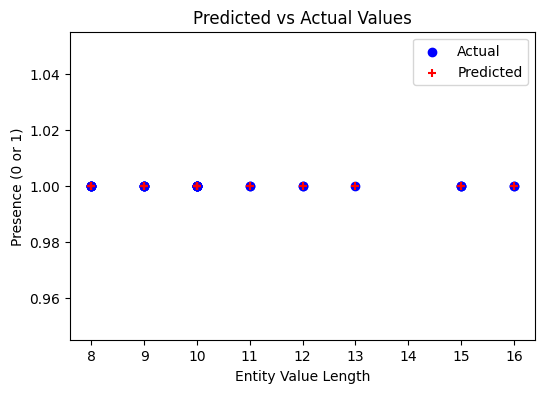

In [84]:
import matplotlib.pyplot as plt
# Predicted vs Actual
plt.figure(figsize=(6, 4))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', marker='+', label='Predicted')
plt.title('Predicted vs Actual Values')
plt.xlabel('Entity Value Length')
plt.ylabel('Presence (0 or 1)')
plt.legend()
plt.show()


# Detection of food and vegetables

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Input,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import numpy as np

In [15]:
data_train_path ="/kaggle/input/fruit-and-vegetable-image-recognition/train"
data_test_path="/kaggle/input/fruit-and-vegetable-image-recognition/test"
data_val_path = "/kaggle/input/fruit-and-vegetable-image-recognition/validation"

In [16]:
img_width = 180
img_height = 180

In [17]:
data_train = tf.keras.utils.image_dataset_from_directory(
data_train_path,
    shuffle= True,
    image_size= (img_width, img_height),
    batch_size = 32,
    validation_split=False
)

Found 3115 files belonging to 36 classes.


In [18]:
data_cat = data_train.class_names
#data_cat

In [19]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_width,img_height),
    batch_size=32,
    shuffle=False,
    validation_split=False
)

Found 351 files belonging to 36 classes.


In [20]:
data_test = tf.keras.utils.image_dataset_from_directory(
data_test_path,
    image_size=(img_width,img_height),
    batch_size=32,
    shuffle=False,
    validation_split=False
)

Found 359 files belonging to 36 classes.


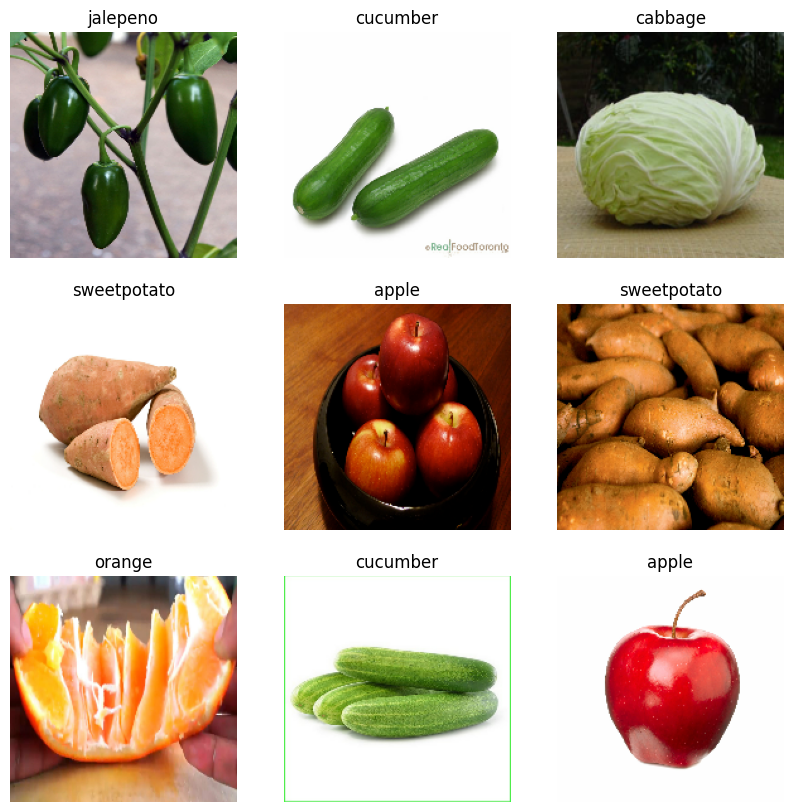

In [21]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

In [22]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Rescaling

# Define the rescaling layer
rescaling = Rescaling(1./255)

# Define the Sequential model
model = Sequential([
    rescaling,  # Rescaling layer
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.2),
    Dense(128),
    Dense(len(data_cat)),
])

model.compile(optimizer='adam', loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
epochs =30
history = model.fit(data_train, validation_data=data_val,epochs=epochs,batch_size=32,verbose=1 )

Epoch 1/30


I0000 00:00:1729411625.619696     298 service.cc:145] XLA service 0x7f4e18007930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729411625.619753     298 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729411625.619758     298 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 4/98 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0150 - loss: 3.7875     

I0000 00:00:1729411631.983763     298 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 543ms/step - accuracy: 0.0611 - loss: 3.4738 - val_accuracy: 0.3932 - val_loss: 2.4170
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.3053 - loss: 2.5063 - val_accuracy: 0.6467 - val_loss: 1.3873
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - accuracy: 0.4850 - loss: 1.8484 - val_accuracy: 0.7407 - val_loss: 0.9955
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 296ms/step - accuracy: 0.6550 - loss: 1.2319 - val_accuracy: 0.8917 - val_loss: 0.5212
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 297ms/step - accuracy: 0.8088 - loss: 0.6691 - val_accuracy: 0.9288 - val_loss: 0.3979
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.8806 - loss: 0.4122 - val_accuracy: 0.9345 - val_loss: 0.3794
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 292ms/step - accuracy: 0.9302 - loss: 0.2959 - val_accuracy: 0.9516 - val_loss: 0.3500
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - accuracy: 0.9552 - loss: 0.1877 - val_accuracy: 0.937

In [26]:
# Save the model
model.save('fruit_classifier_model.h5')
print("Model saved successfully!")

Model saved successfully!


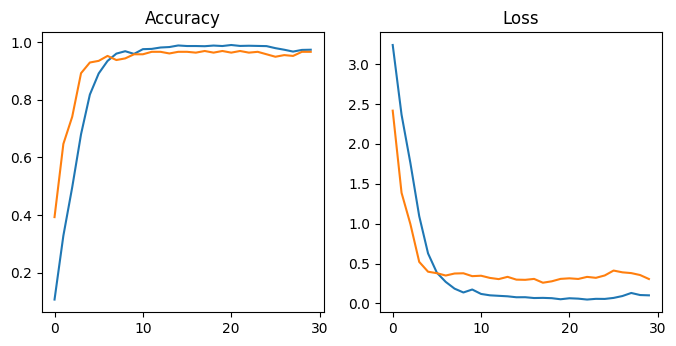

In [27]:
epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(epochs_range, history.history['accuracy'],label='Training Accuracy')
plt.plot(epochs_range , history.history['val_accuracy'],label ='Validation Accuracy')
plt.title('Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs_range , history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Text(0.5, 1.0, 'Eto: apple, veroyatnost : 40.520477294921875')

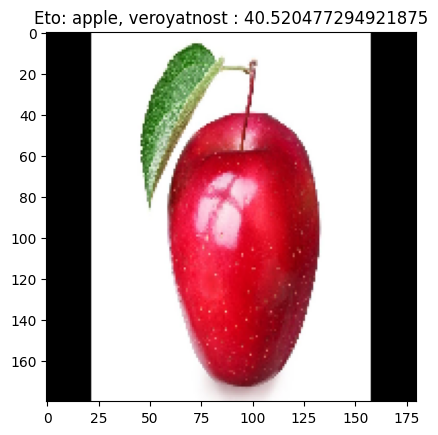

In [28]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
class_names = [
    'apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower',
    'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalapeno',
    'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple',
    'pomegranate', 'potato', 'radish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato',
    'tomato', 'turnip', 'watermelon'
]

img = load_img('/kaggle/input/fruit-and-vegetable-image-recognition/test/apple/Image_2.jpg',target_size=(180,180))
imgconv = img_to_array(img)
img_array = np.expand_dims(imgconv,axis=0) 
pred = np.argmax(model.predict(img_array))
predimg = class_names[pred]
predver = np.max(model.predict(img_array))
pred
plt.imshow(img)
plt.title("Eto: {}, veroyatnost : {}".format (predimg, predver))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
Classification Report:
                precision    recall  f1-score   support

        apple       1.00      0.70      0.82        10
       banana       1.00      0.78      0.88         9
     beetroot       0.91      1.00      0.95        10
  bell pepper       0.91      1.00      0.95        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.90      0.95        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.

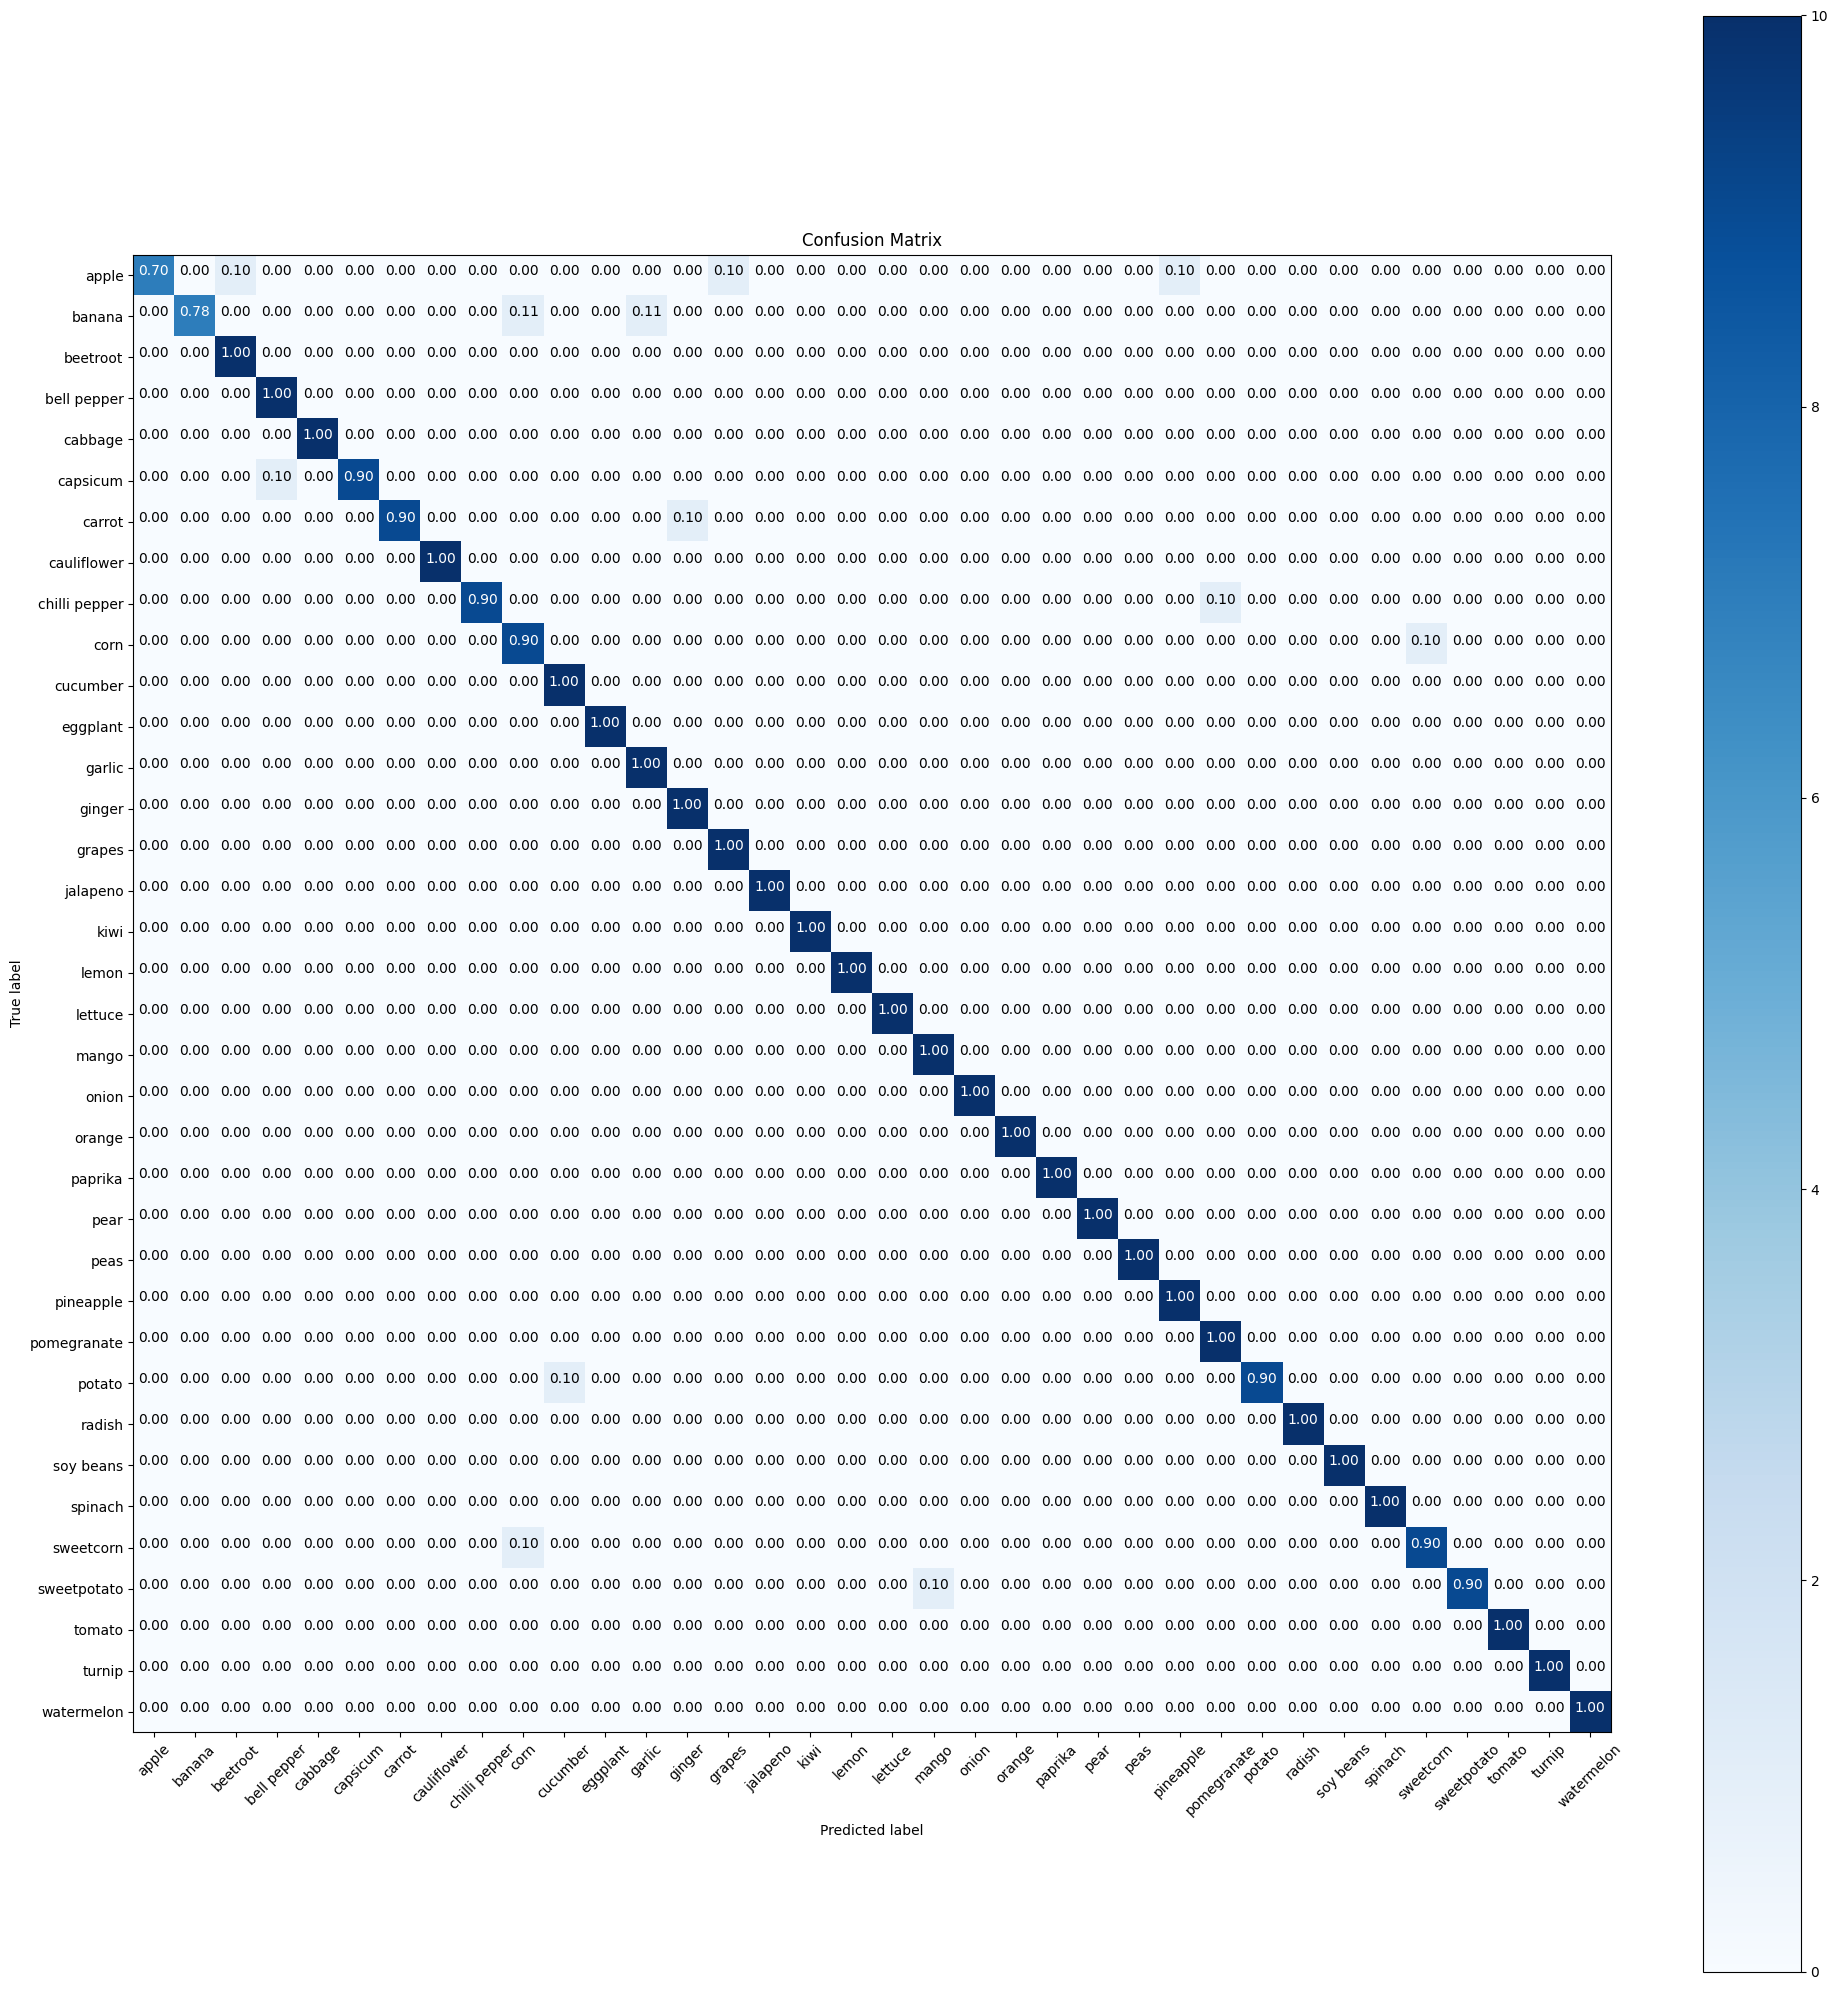

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Function to generate predictions and confusion matrix
def evaluate_model_with_confusion_matrix(model, test_data, class_names):
    true_labels = []
    predicted_labels = []

    # Loop through the test data
    for images, labels in test_data:
        # Ensure the images have the right shape
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)  # Predicted class labels
        
        true_labels.extend(labels)  # Assuming labels are the true labels in test_data
        predicted_labels.extend(predicted_classes)
    
    # Generate and print classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print("Classification Report:\n", report)

    # Plot confusion matrix
    plot_confusion_matrix(true_labels, predicted_labels, class_names)

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming `data_test` contains your test data and `class_names` contains the class labels
evaluate_model_with_confusion_matrix(model, data_test, class_names)


# FreshTrack Vision

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import backend as K

In [2]:
# Function to visualize sample images
def visualize_sample_images(dataset_dir, categories):
    n = len(categories)
    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i, category in enumerate(categories):
        folder = os.path.join(dataset_dir, category)
        image_file = os.listdir(folder)[0]  # Get the first image file in the category folder
        img_path = os.path.join(folder, image_file)
        img = load_img(img_path)
        axs[i].imshow(img)
        axs[i].set_title(category.replace('_', ' '))  # Replace underscores with spaces for better display
        axs[i].axis('off')  # Turn off axis labels
    plt.tight_layout()
    plt.show()

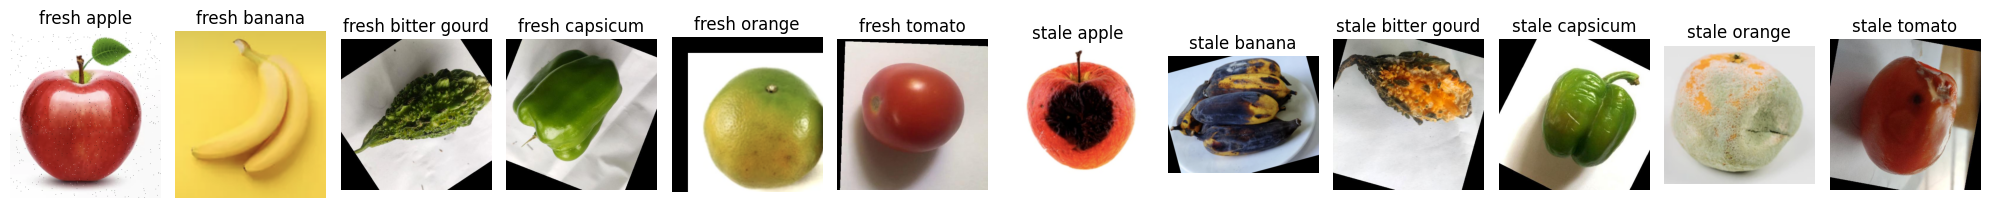

In [3]:
dataset_base_dir = '/kaggle/input/fresh-and-stale-images-of-fruits-and-vegetables'  # Change this to your actual dataset path
categories = [
    'fresh_apple', 'fresh_banana', 'fresh_bitter_gourd', 'fresh_capsicum', 'fresh_orange', 'fresh_tomato',
    'stale_apple', 'stale_banana', 'stale_bitter_gourd', 'stale_capsicum', 'stale_orange', 'stale_tomato'
]

visualize_sample_images(dataset_base_dir, categories)

In [4]:
# Set up data generators
batch_size = 32
img_height = 180
img_width = 180

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of the data for validation
)

In [5]:
# Flow data from directory
train_generator = train_datagen.flow_from_directory(
    dataset_base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 11749 images belonging to 12 classes.
Found 2933 images belonging to 12 classes.


In [6]:
# Function to compute freshness accuracy
import tensorflow as tf

def freshness_accuracy(y_true, y_pred):
    # Map fresh and stale categories to binary values
    fresh_categories = [0, 1, 2, 3, 4, 5]  # Indices of fresh categories
    stale_categories = [6, 7, 8, 9, 10, 11]  # Indices of stale categories

    # Get the predicted and true classes
    y_pred_classes = K.argmax(y_pred, axis=-1)
    y_true_classes = K.argmax(y_true, axis=-1)

    # Group predictions into fresh (0) and stale (1)
    y_pred_freshness = tf.where(tf.reduce_any(tf.equal(tf.expand_dims(y_pred_classes, -1), fresh_categories), axis=-1), 0, 1)
    y_true_freshness = tf.where(tf.reduce_any(tf.equal(tf.expand_dims(y_true_classes, -1), fresh_categories), axis=-1), 0, 1)

    # Return the mean accuracy for freshness
    return K.mean(K.equal(y_true_freshness, y_pred_freshness))

In [7]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')  # Softmax for 12 classes
])

# Compile the model with the custom freshness accuracy metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
              metrics=['accuracy', freshness_accuracy])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,445,260 (20.77 MB)

 Trainable params: 5,445,260 (20.77 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729438195.239065     114 service.cc:145] XLA service 0x7cc3f80055f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729438195.239125     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729438195.239129     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/367 ━━━━━━━━━━━━━━━━━━━━ 1:16:39 13s/step - accuracy: 0.0625 - freshness_accuracy: 0.6250 - loss: 2.4839

I0000 00:00:1729438202.025689     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


367/367 ━━━━━━━━━━━━━━━━━━━━ 230s 593ms/step - accuracy: 0.4214 - freshness_accuracy: 0.6506 - loss: 1.6416 - val_accuracy: 0.7988 - val_freshness_accuracy: 0.8479 - val_loss: 0.5845
Epoch 2/10
  1/367 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.8750 - freshness_accuracy: 0.9375 - loss: 0.3261

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8750 - freshness_accuracy: 0.9375 - loss: 0.3261 - val_accuracy: 0.7619 - val_freshness_accuracy: 0.8571 - val_loss: 0.6269
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 154s 414ms/step - accuracy: 0.7612 - freshness_accuracy: 0.8491 - loss: 0.6446 - val_accuracy: 0.7919 - val_freshness_accuracy: 0.8365 - val_loss: 0.5023
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.8438 - freshness_accuracy: 0.9062 - loss: 0.5254 - val_accuracy: 0.8095 - val_freshness_accuracy: 0.8095 - val_loss: 0.3417
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 152s 409ms/step - accuracy: 0.8267 - freshness_accuracy: 0.8896 - loss: 0.4692 - val_accuracy: 0.8300 - val_freshness_accuracy: 0.8712 - val_loss: 0.4049
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.8125 - freshness_accuracy: 0.8750 - loss: 0.4372 - val_accuracy: 0.9048 - val_freshness_accuracy: 0.9048 - val_loss: 0.1990
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 154s 413m

In [10]:
# Evaluate on the training set for final accuracy and loss, including freshness accuracy
eval_result = model.evaluate(train_generator)
print(f"Training Loss: {eval_result[0]}, Training Accuracy: {eval_result[1]}, Freshness Accuracy: {eval_result[2]}")


368/368 ━━━━━━━━━━━━━━━━━━━━ 121s 328ms/step - accuracy: 0.9159 - freshness_accuracy: 0.9466 - loss: 0.2357
Training Loss: 0.23594465851783752, Training Accuracy: 0.9188016057014465, Freshness Accuracy: 0.94921875


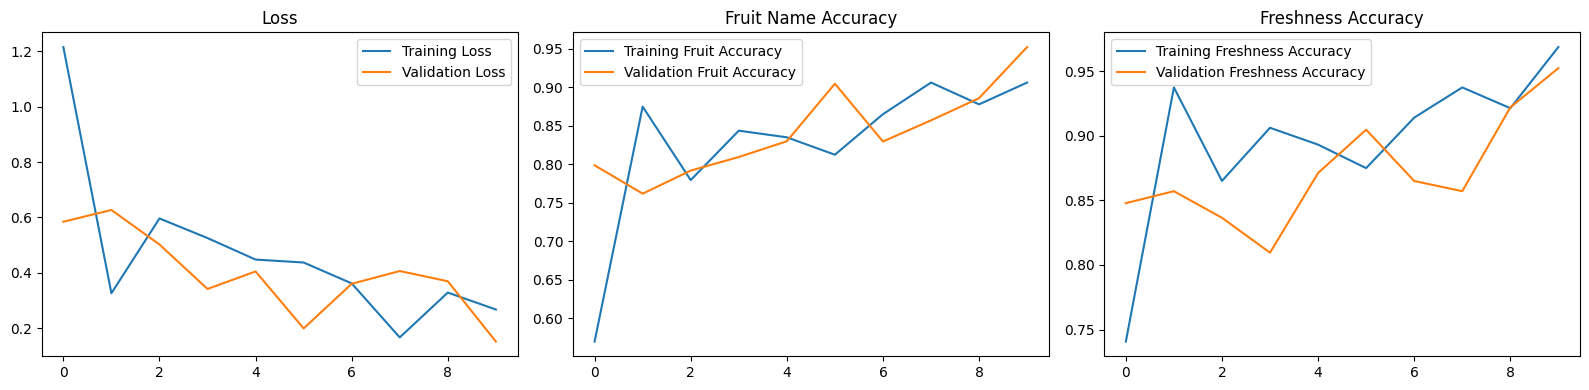

In [11]:
# Plot the results
plt.figure(figsize=(16, 4))

# Plot Loss
plt.subplot(1, 3, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

# Plot Fruit Name Accuracy
plt.subplot(1, 3, 2)
plt.title('Fruit Name Accuracy')
plt.plot(history.history['accuracy'], label='Training Fruit Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Fruit Accuracy')
plt.legend()

# Plot Freshness Accuracy
plt.subplot(1, 3, 3)
plt.title('Freshness Accuracy')
plt.plot(history.history['freshness_accuracy'], label='Training Freshness Accuracy')
plt.plot(history.history['val_freshness_accuracy'], label='Validation Freshness Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


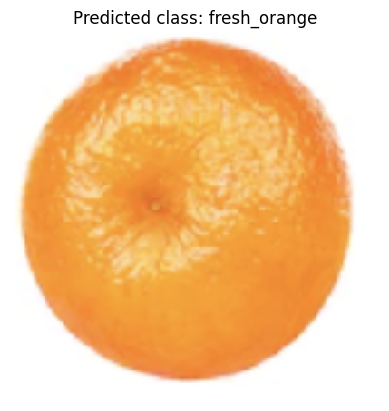

In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def classify_image(image_path, model, class_labels):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])  # Get the index of the highest probability
    predicted_class = class_labels[predicted_class_idx]  # Get the corresponding class label

    # Display the image with the predicted class
    plt.imshow(img)
    plt.title(f"Predicted class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Define the class labels in the same order as the model was trained
class_labels = [
    'fresh_apple', 'fresh_banana', 'fresh_bitter_gourd', 'fresh_capsicum', 'fresh_orange', 'fresh_tomato',
    'stale_apple', 'stale_banana', 'stale_bitter_gourd', 'stale_capsicum', 'stale_orange', 'stale_tomato'
]

# Example usage
image_path = '/kaggle/input/fresh-and-stale-images-of-fruits-and-vegetables/fresh_orange/Screen Shot 2018-06-12 at 11.50.33 PM.png'  # Change this to the path of your image
classify_image(image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


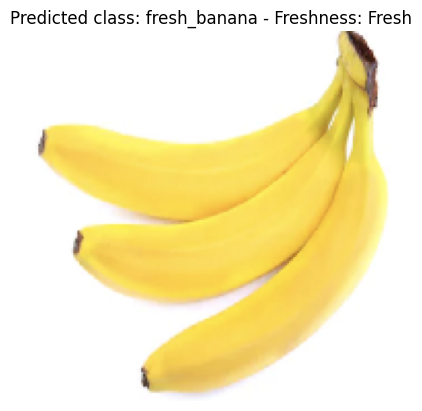

In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define the image size
img_height = 180  # Height of the image
img_width = 180   # Width of the image

def classify_image(image_path, model, class_labels):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Normalize the image array

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])  # Get the index of the highest probability
    predicted_class = class_labels[predicted_class_idx]  # Get the corresponding class label

    # Determine freshness label
    if predicted_class_idx < 3:  # Assuming first 3 classes are fresh
        freshness_label = 'Fresh'
    else:  # Assuming last 3 classes are stale
        freshness_label = 'Stale'

    # Display the image with the predicted class and freshness label
    plt.imshow(img)
    plt.title(f"Predicted class: {predicted_class} - Freshness: {freshness_label}")
    plt.axis('off')
    plt.show()

# Define the class labels in the same order as the model was trained
class_labels = [
    'fresh_apple', 'fresh_banana', 'fresh_bitter_gourd',  # Fresh categories
    'stale_apple', 'stale_banana', 'stale_bitter_gourd'   # Stale categories
]

# Example usage
image_path = '/kaggle/input/fresh-and-stale-images-of-fruits-and-vegetables/fresh_banana/Screen Shot 2018-06-12 at 9.50.31 PM.png'  # Change this to the path of your image
classify_image(image_path, model, class_labels)